### Packages

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Data

### Initial Setting + Functions

In [54]:
condition_map = {
    'rsfMRI_HB6': 'rest',
    'flanker_events': 'task',
    'flanker_events_twitching': 'twitching'
}

exclude_cols = ['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition', 'ADHD/NT', 'Gender']

In [55]:
def convert_diff_df(data):
    # STEP 1: Copy the DataFrame
    df = data.copy()

    # STEP 2: Extract all unique feature names
    # Columns look like 'rest / Averaged_CC', so we split on ' / ' and get the second part
    features = sorted(set(col.split(' / ')[1] for col in df.columns if ' / ' in col))
    conditions = ['rest', 'task', 'twitching']

    # STEP 3: Rename columns to make them easier to work with
    new_columns = {
        f'{cond} / {feature}': f'{cond}_{feature}'
        for cond in conditions
        for feature in features
        if f'{cond} / {feature}' in df.columns
    }
    df = df.rename(columns=new_columns)

    # STEP 4: Compute pairwise differences
    for feature in features:
        col_rest = f'rest_{feature}'
        col_task = f'task_{feature}'
        col_twitch = f'twitching_{feature}'

        if col_rest in df.columns and col_task in df.columns:
            df[f'rest-task_{feature}'] = df[col_rest] - df[col_task]

        if col_rest in df.columns and col_twitch in df.columns:
            df[f'rest-twitching_{feature}'] = df[col_rest] - df[col_twitch]

        if col_task in df.columns and col_twitch in df.columns:
            df[f'task-twitching_{feature}'] = df[col_task] - df[col_twitch]
        df.drop(columns=[f'rest_{feature}', f'task_{feature}', f'twitching_{feature}'], inplace=True)

    # view result
    df.head()

    return df

In [56]:
def get_nodes(connection_columns):
    # Create an empty list to store the distinct components
    nodes = set()

    # Split each region and add parts to the list
    for region in connection_columns:
        parts = region.replace('-', ' ').split()
        nodes.update(parts)

    return list(nodes)

def get_edges(connection_columns, avg_corr):
    # Create an empty list to store edges
    edges = []
    
    for column in connection_columns:
        # Split the column name to extract the two regions involved
        region1, region2 = column.replace('-', ' ').split()

        # Get the correlation value for this connection
        correlation_value = avg_corr[column]

        # Append the edge (with correlation value as weight)
        edges.append((region1, region2, correlation_value))

    return edges

In [57]:
def ttest(matrix_df, merged_df):
    results = []

    for col in matrix_df:
        adhd_vals = merged_df[merged_df['ADHD/NT'] == 'ADHD'][col].dropna()
        nt_vals = merged_df[merged_df['ADHD/NT'] == 'NT'][col].dropna()
        
        stat, p = ttest_ind(adhd_vals, nt_vals, equal_var=False)  # Welch's t-test
        results.append({'Connection': col, 't-stat': stat, 'p-value': p})

    result_df = pd.DataFrame(results)
    return result_df


### Demographic

In [58]:
info = pd.read_excel('Brain_networks/Demographic.xlsx')
info['Participant_ID'] = info['Participant_ID'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))

# Remove duplicates
info = info.drop_duplicates(subset='Participant_ID')

# Reset index (optional)
info = info.reset_index(drop=True)

# Display the result
info.head()

,Participant_ID,ADHD/NT,Gender
0,200,NT,F
1,201,ADHD,F
2,202,NT,F
3,205,NT,F
4,207,NT,F


### Visual Network

In [59]:
# Visual
visual_2021 = pd.read_excel('Brain_networks/Network_CC/Visual_2021.xlsx')
visual_2022 = pd.read_excel('Brain_networks/Network_CC/Visual_2022.xlsx')
visual_2023 = pd.read_excel('Brain_networks/Network_CC/Visual_2023.xlsx')

combined_visual = pd.concat([visual_2021, visual_2022, visual_2023], ignore_index=True)
combined_visual.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010
1,201,rsfMRI_HB6,Condition001.mat,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031
2,202,rsfMRI_HB6,Condition001.mat,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582
3,205,rsfMRI_HB6,Condition001.mat,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152
4,207,rsfMRI_HB6,Condition001.mat,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045


In [60]:
merged_visual = combined_visual.merge(info, on='Participant_ID', how='inner')
merged_visual.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,Condition001.mat,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010,NT,F
1,201,rsfMRI_HB6,Condition001.mat,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031,ADHD,F
2,202,rsfMRI_HB6,Condition001.mat,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582,NT,F
3,205,rsfMRI_HB6,Condition001.mat,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152,NT,F
4,207,rsfMRI_HB6,Condition001.mat,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045,NT,F


In [68]:
print(merged_visual.columns)
matrix_visual = merged_visual.drop(columns=['Condition_matfile', 'Sequence_name'], inplace=False)
matrix_visual.head()

Index(['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition',
       'Medial-Occipital', 'Medial-Lateral(L)', 'Medial-Lateral(R)',
       'Occipital-Lateral(L)', 'Occipital-Lateral(R)', 'Lateral(L)-Lateral(R)',
       'Averaged_CC', 'ADHD/NT', 'Gender'],
      dtype='object')


,Participant_ID,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC,ADHD/NT,Gender
0,200,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010,NT,F
1,201,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031,ADHD,F
2,202,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582,NT,F
3,205,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152,NT,F
4,207,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045,NT,F


#### Difference

In [62]:
matrix_visual['Condition_Simple'] = matrix_visual['Sequence_name'].map(condition_map)

cols = matrix_visual.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Condition_Simple', 'ADHD/NT', 'Gender']).columns.tolist()

pivoted_visual = matrix_visual.pivot_table(
    index='Participant_ID',
    columns='Condition_Simple',
    values=cols
)

pivoted_visual.columns = [f"{cond} / {feat}" for feat, cond in pivoted_visual.columns]
pivoted_visual

,rest / Averaged_CC,task / Averaged_CC,twitching / Averaged_CC,rest / Lateral(L)-Lateral(R),task / Lateral(L)-Lateral(R),twitching / Lateral(L)-Lateral(R),rest / Medial-Lateral(L),task / Medial-Lateral(L),twitching / Medial-Lateral(L),rest / Medial-Lateral(R),...,twitching / Medial-Lateral(R),rest / Medial-Occipital,task / Medial-Occipital,twitching / Medial-Occipital,rest / Occipital-Lateral(L),task / Occipital-Lateral(L),twitching / Occipital-Lateral(L),rest / Occipital-Lateral(R),task / Occipital-Lateral(R),twitching / Occipital-Lateral(R)
Participant_ID,,,,,,,,,,,,,,,,,,,,,
1,0.653680,0.66210,0.45388,1.216000,0.93961,0.97759,0.386400,0.48858,0.26475,0.259650,...,0.151090,0.517840,0.710530,0.544040,0.868110,0.924420,0.452960,0.674080,0.590730,0.332870
2,0.668250,0.61321,0.55770,1.442800,0.91259,0.73418,0.332970,0.72222,0.49712,0.265220,...,0.471190,0.153240,0.359860,0.769480,1.036300,0.707950,0.545310,0.778980,0.326040,0.328940
3,0.812700,0.44460,0.74240,1.206300,0.65576,1.07220,0.739490,0.31935,0.61810,0.793150,...,0.785030,0.753460,0.204550,0.637350,0.840360,0.491850,0.647080,0.543420,0.517070,0.694610
4,0.420540,0.53195,0.55579,1.390900,1.17700,1.14950,0.489230,0.40570,0.29370,0.607900,...,0.381660,-0.064901,0.318370,0.228800,0.107560,0.491090,0.708200,-0.007452,0.531460,0.572860
5,0.564070,0.73341,0.74593,1.174500,0.99247,1.00550,0.515200,0.55798,0.70433,0.503850,...,0.748670,0.279980,0.455870,0.364410,0.596600,0.931900,0.830430,0.314270,0.659670,0.822240
6,0.934690,0.64839,0.53654,1.465800,1.02510,1.03590,0.851150,0.92573,0.28862,0.987280,...,0.212550,0.828810,0.342320,0.425770,0.699210,0.407440,0.558790,0.775870,0.462780,0.697600
7,0.025276,0.84925,0.66546,0.197410,0.74148,0.73889,0.439790,1.05770,1.14930,0.172650,...,0.819460,-0.264380,0.840670,0.579310,-0.358300,0.816600,0.537140,-0.035513,0.745960,0.168670
8,-0.073628,0.67154,0.71873,-0.024089,1.28290,1.02210,0.306530,0.67852,0.72551,-0.403360,...,0.712320,-0.152270,0.353060,0.526390,-0.217840,0.572540,0.595500,0.049259,0.434980,0.730570
9,-0.047105,0.54427,0.61914,0.114660,0.94816,0.91673,0.052049,0.73618,0.67387,0.107170,...,0.525580,-0.253300,0.175520,0.505630,-0.168860,0.524070,0.677730,-0.134350,0.137570,0.415300


In [63]:
visual_diff = convert_diff_df(pivoted_visual)
visual_diff.head()

visual_diff.to_csv('networks/visual_diff.csv', index=True)

#### Average Correlation

In [64]:
matrix_visual_ADHD = matrix_visual[matrix_visual['ADHD/NT'] == 'ADHD'].drop(columns=['ADHD/NT'])
matrix_visual_NT = matrix_visual[matrix_visual['ADHD/NT'] == 'NT'].drop(columns=['ADHD/NT'])

connection_columns = matrix_visual.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Gender', 'Condition_Simple', 'ADHD/NT']).columns.tolist()
print(connection_columns)

['Medial-Occipital', 'Medial-Lateral(L)', 'Medial-Lateral(R)', 'Occipital-Lateral(L)', 'Occipital-Lateral(R)', 'Lateral(L)-Lateral(R)', 'Averaged_CC']


In [65]:
# ADHD
avg_corr_visual_adhd = matrix_visual_ADHD[connection_columns].mean().round(4)
print(f'<Average visual network correlation for ADHD> \n{avg_corr_visual_adhd}\n')

# NT
avg_corr_visual_nt = matrix_visual_NT[connection_columns].mean().round(4)
print(f'<Average visual network correlation for NT> \n{avg_corr_visual_nt}\n')

# DIFF
avg_diff_visual = abs(avg_corr_visual_nt-avg_corr_visual_adhd)
print(f'<Average difference between ADHD and NT for Visual Network>\n{avg_diff_visual}')

<Average visual network correlation for ADHD> 
Medial-Occipital         0.3621
Medial-Lateral(L)        0.6609
Medial-Lateral(R)        0.5586
Occipital-Lateral(L)     0.4959
Occipital-Lateral(R)     0.4020
Lateral(L)-Lateral(R)    0.9840
Averaged_CC              0.5772
dtype: float64

<Average visual network correlation for NT> 
Medial-Occipital         0.4784
Medial-Lateral(L)        0.5583
Medial-Lateral(R)        0.4713
Occipital-Lateral(L)     0.5768
Occipital-Lateral(R)     0.4652
Lateral(L)-Lateral(R)    1.0736
Averaged_CC              0.6039
dtype: float64

<Average difference between ADHD and NT for Visual Network>
Medial-Occipital         0.1163
Medial-Lateral(L)        0.1026
Medial-Lateral(R)        0.0873
Occipital-Lateral(L)     0.0809
Occipital-Lateral(R)     0.0632
Lateral(L)-Lateral(R)    0.0896
Averaged_CC              0.0267
dtype: float64


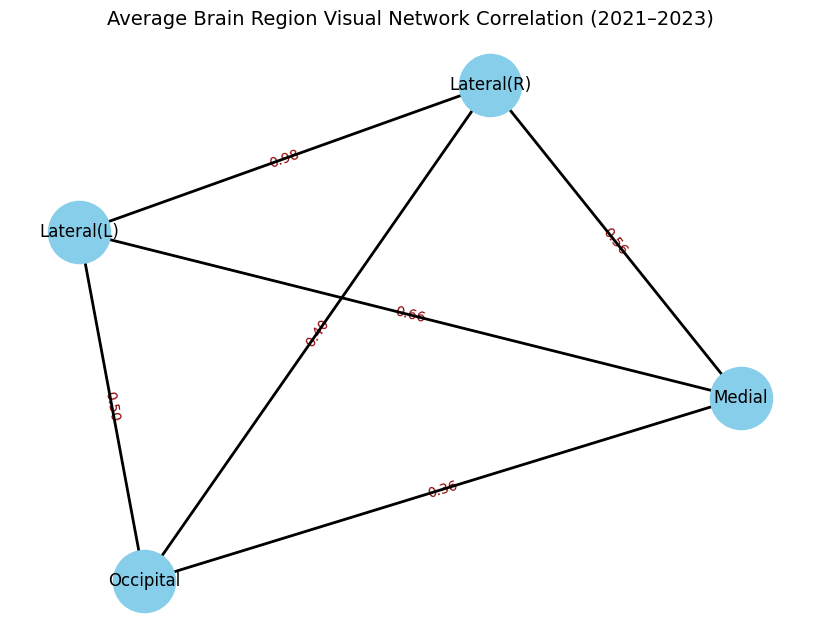

In [66]:
# Define nodes
nodes = get_nodes(connection_columns[:-1])

# Create edge list from average correlations
edges = get_edges(connection_columns[:-1], avg_corr_visual_adhd)

# Create graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Visual layout
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')}

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')
nx.draw_networkx_edges(G, pos, width=2)
plt.title("Average Brain Region Visual Network Correlation (2021–2023)", fontsize=14)
plt.show()

#### Statistical Test

In [74]:
exclude_cols

['Participant_ID',
 'Sequence_name',
 'Condition_matfile',
 'Condition',
 'ADHD/NT',
 'Gender']

In [76]:
# matrix_visual = merged_visual.drop(columns=['exclude_cols'], inplace=False)
matrix_visual_ADHD = matrix_visual[matrix_visual['ADHD/NT'] == 'ADHD'].drop(columns=['ADHD/NT'])
matrix_visual_NT = matrix_visual[matrix_visual['ADHD/NT'] == 'NT'].drop(columns=['ADHD/NT'])

# connection_columns = matrix_visual.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Gender', 'Condition_Simple', 'ADHD/NT']).columns.tolist()
# print(connection_columns)

In [16]:
visual_ttest = ttest(matrix_visual, merged_visual)
visual_ttest

,Connection,t-stat,p-value
0,Medial-Occipital,-2.894361,0.004350
1,Medial-Lateral(L),2.840420,0.005098
2,Medial-Lateral(R),2.149936,0.033220
3,Occipital-Lateral(L),-2.074489,0.039767
4,Occipital-Lateral(R),-1.730093,0.085702
5,Lateral(L)-Lateral(R),-1.775818,0.077765
6,Averaged_CC,-1.018404,0.309983


In [17]:
# FDR 보정
visual_ttest['FDR_corrected_p'] = multipletests(visual_ttest['p-value'], method='fdr_bh')[1]
visual_ttest['Significant'] = visual_ttest['FDR_corrected_p'] < 0.05
visual_ttest.head()

,Connection,t-stat,p-value,FDR_corrected_p,Significant
0,Medial-Occipital,-2.894361,0.004350,0.017844,True
1,Medial-Lateral(L),2.840420,0.005098,0.017844,True
2,Medial-Lateral(R),2.149936,0.033220,0.069592,False
3,Occipital-Lateral(L),-2.074489,0.039767,0.069592,False
4,Occipital-Lateral(R),-1.730093,0.085702,0.099986,False


In [18]:
# 유의한 연결만 보기
significant_connections_visual = visual_ttest[visual_ttest['Significant']]
print(significant_connections_visual)

          Connection    t-stat   p-value  FDR_corrected_p  Significant
0   Medial-Occipital -2.894361  0.004350         0.017844         True
1  Medial-Lateral(L)  2.840420  0.005098         0.017844         True


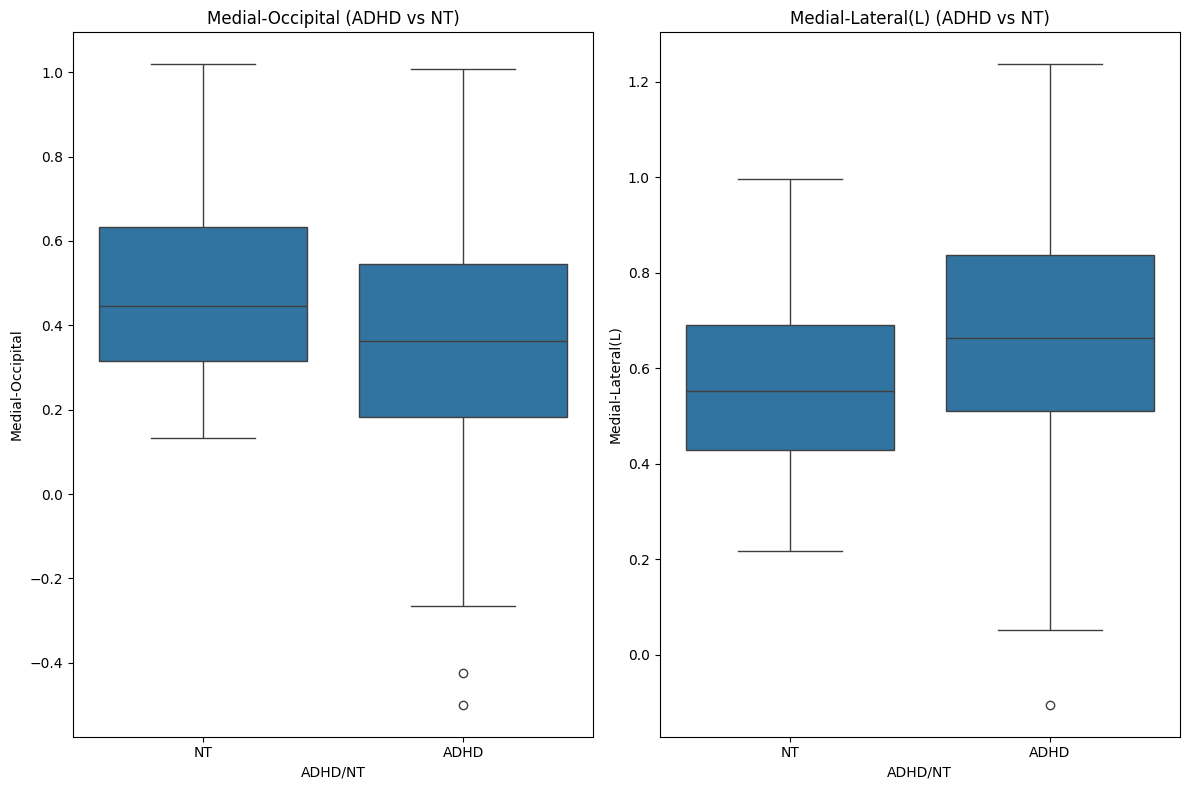

In [19]:
# 가장 유의한 연결 시각화
top_conn_visual_1 = significant_connections_visual.sort_values('FDR_corrected_p').iloc[0]['Connection']
top_conn_visual_2 = significant_connections_visual.sort_values('FDR_corrected_p').iloc[1]['Connection']

# 그래프 크기와 subplot 설정
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# 첫 번째 boxplot
sns.boxplot(x='ADHD/NT', y=top_conn_visual_1, data=merged_visual, ax=axes[0])
axes[0].set_title(f'{top_conn_visual_1} (ADHD vs NT)')

# 두 번째 boxplot
sns.boxplot(x='ADHD/NT', y=top_conn_visual_2, data=merged_visual, ax=axes[1])
axes[1].set_title(f'{top_conn_visual_2} (ADHD vs NT)')

plt.tight_layout()
plt.show()

### Salience Network

In [20]:
# Salience
salience_2021 = pd.read_excel('Brain_networks/Network_CC/Salience_2021.xlsx')
salience_2022 = pd.read_excel('Brain_networks/Network_CC/Salience_2022.xlsx')
salience_2023 = pd.read_excel('Brain_networks/Network_CC/Salience_2023.xlsx')

combined_salience = pd.concat([salience_2021, salience_2022, salience_2023], ignore_index=True)
combined_salience.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),...,AInsula(R)-RPFC(R),AInsula(R)-SMG(L),AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.38244,0.42946,0.47293,0.68623,0.476520,0.147830,...,0.24826,0.40205,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480
1,201,rsfMRI_HB6,Condition001.mat,rest,0.26701,0.30673,0.26035,0.47045,0.036738,0.296230,...,0.44240,0.13552,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922
2,202,rsfMRI_HB6,Condition001.mat,rest,0.39955,0.76758,0.18989,0.30054,0.330140,0.064600,...,0.32921,0.48753,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151
3,205,rsfMRI_HB6,Condition001.mat,rest,0.51393,0.60648,0.83598,0.76121,0.429540,-0.027161,...,0.64889,0.65663,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836
4,207,rsfMRI_HB6,Condition001.mat,rest,0.50032,0.54461,0.35094,0.37688,0.286510,0.246030,...,0.32564,0.47198,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589


In [21]:
merged_salience = combined_salience.merge(info, on='Participant_ID', how='inner')
merged_salience.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),...,AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,Condition001.mat,rest,0.38244,0.42946,0.47293,0.68623,0.476520,0.147830,...,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480,NT,F
1,201,rsfMRI_HB6,Condition001.mat,rest,0.26701,0.30673,0.26035,0.47045,0.036738,0.296230,...,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922,ADHD,F
2,202,rsfMRI_HB6,Condition001.mat,rest,0.39955,0.76758,0.18989,0.30054,0.330140,0.064600,...,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151,NT,F
3,205,rsfMRI_HB6,Condition001.mat,rest,0.51393,0.60648,0.83598,0.76121,0.429540,-0.027161,...,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836,NT,F
4,207,rsfMRI_HB6,Condition001.mat,rest,0.50032,0.54461,0.35094,0.37688,0.286510,0.246030,...,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589,NT,F


In [22]:
print(merged_salience.columns)
matrix_salience = merged_salience.drop(columns=['Condition_matfile'], inplace=False)
matrix_salience.head()

Index(['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition',
       'ACC-AInsula(L)', 'ACC-AInsula(R)', 'ACC-RPFC(L)', 'ACC-RPFC(R)',
       'ACC-SMG(L)', 'ACC-SMG(R)', 'AInsula(L)-AInsula(R)',
       'AInsula(L)-RPFC(L)', 'AInsula(L)-RPFC(R)', 'AInsula(L)-SMG(L)',
       'AInsula(L)-SMG(R)', 'AInsula(R)-RPFC(L)', 'AInsula(R)-RPFC(R)',
       'AInsula(R)-SMG(L)', 'AInsula(R)-SMG(R)', 'RPFC(L)-RPFC(R)',
       'RPFC(L)-SMG(L)', 'RPFC(L)-SMG(R)', 'RPFC(R)-SMG(L)', 'RPFC(R)-SMG(R)',
       'SMG(L)-SMG(R)', 'Averaged_CC', 'ADHD/NT', 'Gender'],
      dtype='object')


,Participant_ID,Sequence_name,Condition,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),AInsula(L)-AInsula(R),...,AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,rest,0.38244,0.42946,0.47293,0.68623,0.476520,0.147830,0.40015,...,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480,NT,F
1,201,rsfMRI_HB6,rest,0.26701,0.30673,0.26035,0.47045,0.036738,0.296230,0.59892,...,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922,ADHD,F
2,202,rsfMRI_HB6,rest,0.39955,0.76758,0.18989,0.30054,0.330140,0.064600,0.22255,...,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151,NT,F
3,205,rsfMRI_HB6,rest,0.51393,0.60648,0.83598,0.76121,0.429540,-0.027161,0.41983,...,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836,NT,F
4,207,rsfMRI_HB6,rest,0.50032,0.54461,0.35094,0.37688,0.286510,0.246030,0.63985,...,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589,NT,F


#### Difference

In [23]:
matrix_salience['Condition_Simple'] = matrix_salience['Sequence_name'].map(condition_map)

cols = matrix_salience.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Condition_Simple', 'ADHD/NT', 'Gender']).columns.tolist()

pivoted_salience = matrix_salience.pivot_table(
    index='Participant_ID',
    columns='Condition_Simple',
    values=cols
)

pivoted_salience.columns = [f"{cond} / {feat}" for feat, cond in pivoted_salience.columns]
pivoted_salience

,rest / ACC-AInsula(L),task / ACC-AInsula(L),twitching / ACC-AInsula(L),rest / ACC-AInsula(R),task / ACC-AInsula(R),twitching / ACC-AInsula(R),rest / ACC-RPFC(L),task / ACC-RPFC(L),twitching / ACC-RPFC(L),rest / ACC-RPFC(R),...,twitching / RPFC(L)-SMG(R),rest / RPFC(R)-SMG(L),task / RPFC(R)-SMG(L),twitching / RPFC(R)-SMG(L),rest / RPFC(R)-SMG(R),task / RPFC(R)-SMG(R),twitching / RPFC(R)-SMG(R),rest / SMG(L)-SMG(R),task / SMG(L)-SMG(R),twitching / SMG(L)-SMG(R)
Participant_ID,,,,,,,,,,,,,,,,,,,,,
1,1.318400,0.531400,0.597210,1.000300,0.507240,0.320280,0.556930,0.495950,0.444490,0.829770,...,0.475400,0.475320,0.544050,0.512470,0.481350,0.285280,0.406220,1.095900,0.488750,0.709530
2,0.567740,0.156070,0.558810,0.548410,0.272890,0.704240,0.583230,0.174790,0.442350,0.520190,...,0.395750,-0.085403,-0.016237,-0.093412,0.144160,0.193490,0.515980,0.959670,0.462310,0.234090
3,0.356850,0.627650,0.316910,0.739810,0.357110,0.631490,0.666610,0.635900,0.574220,0.818390,...,0.493570,1.129000,0.581630,0.963180,0.976700,0.969390,0.738810,1.119000,0.829740,0.616470
4,0.781120,0.273300,0.368980,0.676760,-0.094440,0.121330,0.605350,0.097125,0.936520,0.597300,...,0.306340,0.462530,0.338260,0.513610,0.610340,0.409400,0.591690,0.617950,0.501220,0.886190
5,0.338950,0.554610,0.166140,0.516020,0.498320,0.150470,0.589290,0.604500,-0.147850,0.489280,...,-0.112640,0.521150,0.549970,0.266790,0.683390,0.551860,0.063167,0.759860,0.784820,0.650210
6,0.862990,0.520900,0.487900,0.955910,0.653920,0.766810,0.286510,0.431670,0.756170,0.727500,...,0.390630,0.582920,0.248680,0.441160,0.454000,0.129740,0.571640,1.091000,0.807690,1.059000
7,0.108050,0.735840,0.814900,0.128080,0.694320,0.947120,-0.158140,0.368700,0.552520,-0.153660,...,0.453610,0.332670,0.165530,0.432930,0.256730,0.642890,0.360500,0.541190,0.233370,0.630160
8,0.642420,0.269880,0.725750,0.066518,0.369310,0.796500,-0.038758,-0.011158,-0.092055,-0.594710,...,-0.148230,0.446880,0.488850,0.265260,0.344400,0.429830,0.298110,0.616040,0.836620,0.818550
9,0.216030,0.698420,0.136870,0.146740,0.660480,0.273140,-0.217540,0.611290,0.169640,-0.442030,...,0.281170,0.036377,0.480210,0.098933,0.682450,0.510310,0.059985,0.392460,1.135300,0.804310


In [24]:
salience_diff = convert_diff_df(pivoted_salience)
salience_diff.head()

salience_diff.to_csv('networks/salience_diff.csv', index=True)

#### Average Correlation

In [25]:
matrix_salience_ADHD = matrix_salience[matrix_salience['ADHD/NT'] == 'ADHD'].drop(columns=['ADHD/NT'])
matrix_salience_NT = matrix_salience[matrix_salience['ADHD/NT'] == 'NT'].drop(columns=['ADHD/NT'])

connection_columns = matrix_salience.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Gender', 'Condition_Simple', 'ADHD/NT']).columns.tolist()
print(connection_columns)

['ACC-AInsula(L)', 'ACC-AInsula(R)', 'ACC-RPFC(L)', 'ACC-RPFC(R)', 'ACC-SMG(L)', 'ACC-SMG(R)', 'AInsula(L)-AInsula(R)', 'AInsula(L)-RPFC(L)', 'AInsula(L)-RPFC(R)', 'AInsula(L)-SMG(L)', 'AInsula(L)-SMG(R)', 'AInsula(R)-RPFC(L)', 'AInsula(R)-RPFC(R)', 'AInsula(R)-SMG(L)', 'AInsula(R)-SMG(R)', 'RPFC(L)-RPFC(R)', 'RPFC(L)-SMG(L)', 'RPFC(L)-SMG(R)', 'RPFC(R)-SMG(L)', 'RPFC(R)-SMG(R)', 'SMG(L)-SMG(R)', 'Averaged_CC']


In [26]:
# ADHD
avg_corr_salience_adhd = matrix_salience_ADHD[connection_columns].mean().round(4)
print(f'<Average Salience network correlation for ADHD> \n{avg_corr_salience_adhd}')

<Average Salience network correlation for ADHD> 
ACC-AInsula(L)           0.5023
ACC-AInsula(R)           0.4937
ACC-RPFC(L)              0.4727
ACC-RPFC(R)              0.5165
ACC-SMG(L)               0.2600
ACC-SMG(R)               0.3076
AInsula(L)-AInsula(R)    0.7495
AInsula(L)-RPFC(L)       0.4070
AInsula(L)-RPFC(R)       0.3199
AInsula(L)-SMG(L)        0.4673
AInsula(L)-SMG(R)        0.4225
AInsula(R)-RPFC(L)       0.3081
AInsula(R)-RPFC(R)       0.4584
AInsula(R)-SMG(L)        0.4457
AInsula(R)-SMG(R)        0.5586
RPFC(L)-RPFC(R)          0.7257
RPFC(L)-SMG(L)           0.3109
RPFC(L)-SMG(R)           0.2864
RPFC(R)-SMG(L)           0.3050
RPFC(R)-SMG(R)           0.4393
SMG(L)-SMG(R)            0.6517
Averaged_CC              0.4480
dtype: float64


In [27]:
# NT
avg_corr_salience_nt = matrix_salience_NT[connection_columns].mean().round(4)
print(f'<Average Salience network correlation for NT> \n{avg_corr_salience_nt}')

<Average Salience network correlation for NT> 
ACC-AInsula(L)           0.5596
ACC-AInsula(R)           0.5117
ACC-RPFC(L)              0.5134
ACC-RPFC(R)              0.5428
ACC-SMG(L)               0.2856
ACC-SMG(R)               0.3329
AInsula(L)-AInsula(R)    0.7738
AInsula(L)-RPFC(L)       0.4866
AInsula(L)-RPFC(R)       0.3957
AInsula(L)-SMG(L)        0.4719
AInsula(L)-SMG(R)        0.4277
AInsula(R)-RPFC(L)       0.3878
AInsula(R)-RPFC(R)       0.5309
AInsula(R)-SMG(L)        0.4125
AInsula(R)-SMG(R)        0.5453
RPFC(L)-RPFC(R)          0.7804
RPFC(L)-SMG(L)           0.4011
RPFC(L)-SMG(R)           0.3204
RPFC(R)-SMG(L)           0.3414
RPFC(R)-SMG(R)           0.4283
SMG(L)-SMG(R)            0.6668
Averaged_CC              0.4817
dtype: float64


In [28]:
# DIFF
avg_diff_salience = abs(avg_corr_salience_nt - avg_corr_salience_adhd)
print(f'<Average difference between ADHD and NT for Salience Network>\n{avg_diff_salience}')

<Average difference between ADHD and NT for Salience Network>
ACC-AInsula(L)           0.0573
ACC-AInsula(R)           0.0180
ACC-RPFC(L)              0.0407
ACC-RPFC(R)              0.0263
ACC-SMG(L)               0.0256
ACC-SMG(R)               0.0253
AInsula(L)-AInsula(R)    0.0243
AInsula(L)-RPFC(L)       0.0796
AInsula(L)-RPFC(R)       0.0758
AInsula(L)-SMG(L)        0.0046
AInsula(L)-SMG(R)        0.0052
AInsula(R)-RPFC(L)       0.0797
AInsula(R)-RPFC(R)       0.0725
AInsula(R)-SMG(L)        0.0332
AInsula(R)-SMG(R)        0.0133
RPFC(L)-RPFC(R)          0.0547
RPFC(L)-SMG(L)           0.0902
RPFC(L)-SMG(R)           0.0340
RPFC(R)-SMG(L)           0.0364
RPFC(R)-SMG(R)           0.0110
SMG(L)-SMG(R)            0.0151
Averaged_CC              0.0337
dtype: float64


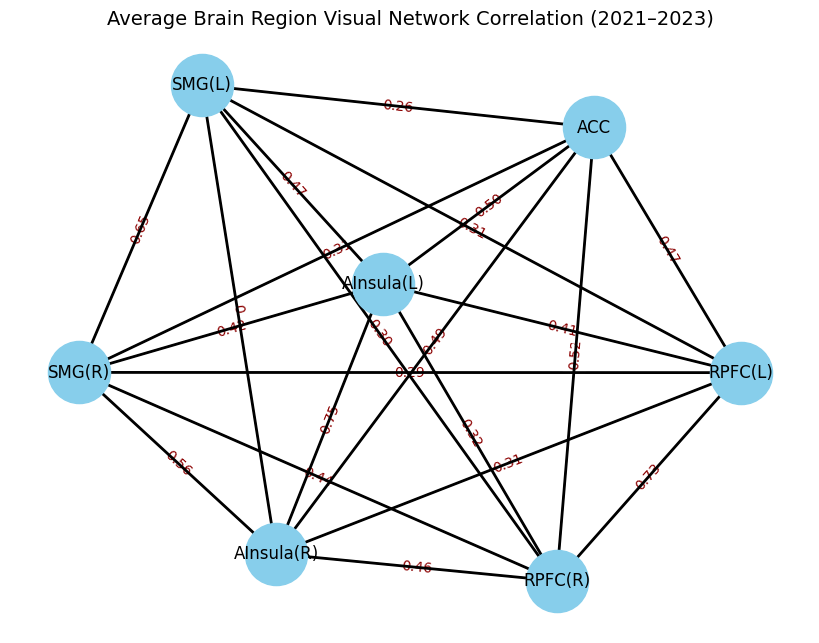

In [29]:
# Define nodes
nodes = get_nodes(connection_columns[:-1])

# Create edge list from average correlations
edges = get_edges(connection_columns[:-1], avg_corr_salience_adhd)

# Create graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Visual layout
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')}

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')
nx.draw_networkx_edges(G, pos, width=2)
plt.title("Average Brain Region Visual Network Correlation (2021–2023)", fontsize=14)
plt.show()


#### Statistical Test

In [30]:
matrix_salience = merged_salience.drop(columns=exclude_cols, inplace=False)
matrix_salience

,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),AInsula(L)-AInsula(R),AInsula(L)-RPFC(L),AInsula(L)-RPFC(R),AInsula(L)-SMG(L),...,AInsula(R)-RPFC(R),AInsula(R)-SMG(L),AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC
0,0.382440,0.429460,0.472930,0.68623,0.476520,0.147830,0.40015,0.63142,0.168550,0.18318,...,0.24826,0.40205,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480
1,0.267010,0.306730,0.260350,0.47045,0.036738,0.296230,0.59892,0.81091,0.622680,0.69481,...,0.44240,0.13552,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922
2,0.399550,0.767580,0.189890,0.30054,0.330140,0.064600,0.22255,0.55078,0.070210,0.37311,...,0.32921,0.48753,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151
3,0.513930,0.606480,0.835980,0.76121,0.429540,-0.027161,0.41983,0.29928,0.298850,0.20358,...,0.64889,0.65663,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836
4,0.500320,0.544610,0.350940,0.37688,0.286510,0.246030,0.63985,0.32830,-0.030044,0.41884,...,0.32564,0.47198,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.108040,-0.053046,0.018281,0.22387,0.128580,0.075049,0.66824,0.30223,0.292830,0.62454,...,0.24739,0.48571,0.22261,0.77728,0.42909,-0.043713,0.52637,0.336260,0.39823,0.30260
164,0.439390,0.373290,0.561870,0.68485,0.063184,0.251910,0.75410,0.69222,0.804900,0.43470,...,0.78625,0.28172,0.45118,0.86703,0.52019,0.676830,0.35556,0.696920,0.86619,0.55675
165,0.375380,0.497450,0.540720,0.69472,0.334230,0.593660,0.70754,0.35239,0.355350,0.10689,...,0.67692,0.21940,0.22705,0.76732,0.15310,0.054180,0.24951,0.420620,0.69513,0.41160
166,0.542200,0.523650,0.525500,0.59552,0.004901,0.551280,1.25200,1.00690,0.749790,0.52020,...,1.04540,0.58470,1.08980,1.03160,0.42187,0.934180,0.37550,1.097900,0.48179,0.72997


In [31]:
salience_ttest = ttest(matrix_salience, merged_salience)
salience_ttest

,Connection,t-stat,p-value
0,ACC-AInsula(L),-1.350075,0.179392
1,ACC-AInsula(R),-0.426824,0.670152
2,ACC-RPFC(L),-1.044065,0.298302
3,ACC-RPFC(R),-0.617687,0.537841
4,ACC-SMG(L),-0.728975,0.467273
5,ACC-SMG(R),-0.683393,0.495847
6,AInsula(L)-AInsula(R),-0.572208,0.568093
7,AInsula(L)-RPFC(L),-1.982731,0.049718
8,AInsula(L)-RPFC(R),-1.704702,0.090852
9,AInsula(L)-SMG(L),-0.114216,0.909240


In [32]:
# FDR 보정
salience_ttest['FDR_corrected_p'] = multipletests(salience_ttest['p-value'], method='fdr_bh')[1]
salience_ttest['Significant'] = salience_ttest['FDR_corrected_p'] < 0.05
salience_ttest.head()

,Connection,t-stat,p-value,FDR_corrected_p,Significant
0,ACC-AInsula(L),-1.350075,0.179392,0.493327,False
1,ACC-AInsula(R),-0.426824,0.670152,0.867255,False
2,ACC-RPFC(L),-1.044065,0.298302,0.729184,False
3,ACC-RPFC(R),-0.617687,0.537841,0.781128,False
4,ACC-SMG(L),-0.728975,0.467273,0.779188,False


In [33]:
# 유의한 연결만 보기
significant_connections_salience = salience_ttest[salience_ttest['Significant']]
print(significant_connections_salience)

Empty DataFrame
Columns: [Connection, t-stat, p-value, FDR_corrected_p, Significant]
Index: []


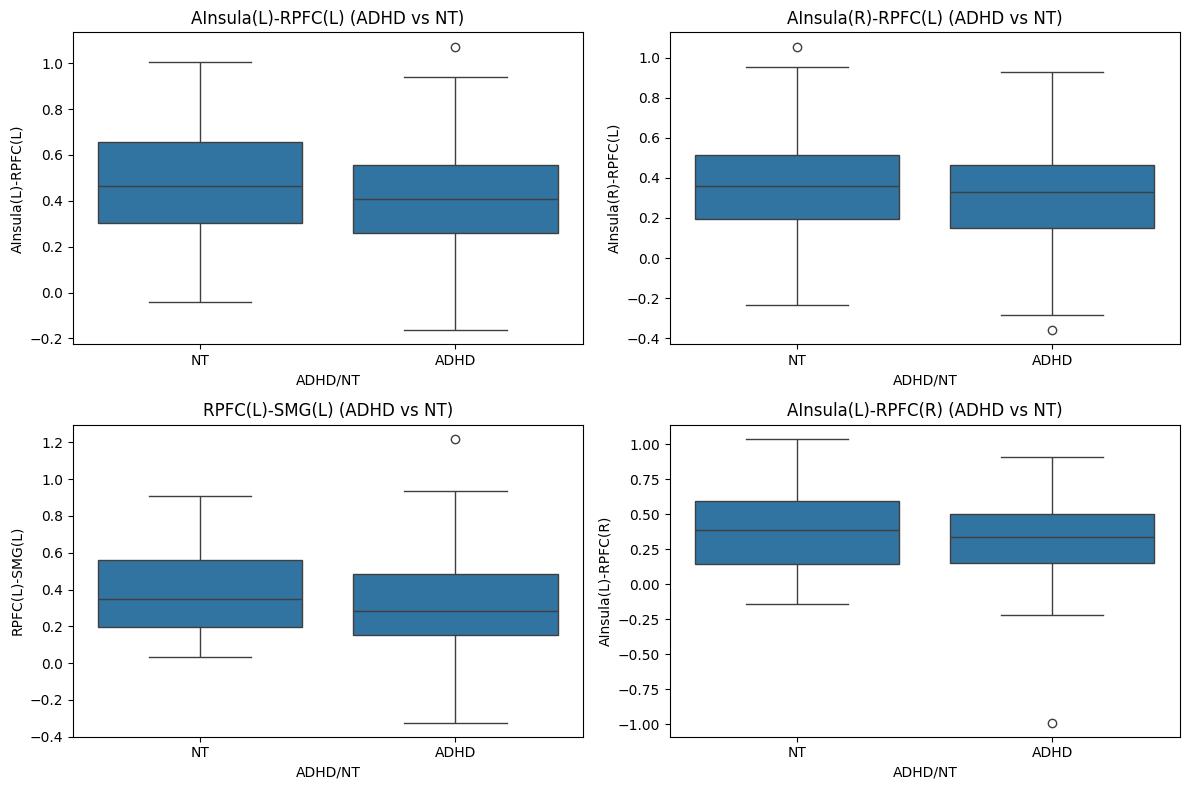

In [34]:
# 가장 유의한 연결 시각화
top_conn_salience_1 = salience_ttest.sort_values('FDR_corrected_p').iloc[0]['Connection']
top_conn_salience_2 = salience_ttest.sort_values('FDR_corrected_p').iloc[1]['Connection']
top_conn_salience_3 = salience_ttest.sort_values('FDR_corrected_p').iloc[2]['Connection']
top_conn_salience_4 = salience_ttest.sort_values('FDR_corrected_p').iloc[3]['Connection']

# 그래프 크기와 subplot 설정
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.boxplot(x='ADHD/NT', y=top_conn_salience_1, data=merged_salience, ax=axes[0, 0])
axes[0, 0].set_title(f'{top_conn_salience_1} (ADHD vs NT)')

sns.boxplot(x='ADHD/NT', y=top_conn_salience_2, data=merged_salience, ax=axes[0, 1])
axes[0, 1].set_title(f'{top_conn_salience_2} (ADHD vs NT)')

sns.boxplot(x='ADHD/NT', y=top_conn_salience_3, data=merged_salience, ax=axes[1, 0])
axes[1, 0].set_title(f'{top_conn_salience_3} (ADHD vs NT)')

sns.boxplot(x='ADHD/NT', y=top_conn_salience_4, data=merged_salience, ax=axes[1, 1])
axes[1, 1].set_title(f'{top_conn_salience_4} (ADHD vs NT)')

plt.tight_layout()
plt.show()

### FrontoParietal (Central Executive)

In [35]:
# FrontoParietal
fp_2021 = pd.read_excel('Brain_networks/Network_CC/FP_2021.xlsx')
fp_2022 = pd.read_excel('Brain_networks/Network_CC/FP_2022.xlsx')
fp_2023 = pd.read_excel('Brain_networks/Network_CC/FP_2023.xlsx')

combined_fp = pd.concat([fp_2021, fp_2022, fp_2023], ignore_index=True)
combined_fp.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524
1,201,rsfMRI_HB6,Condition001.mat,rest,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505
2,202,rsfMRI_HB6,Condition001.mat,rest,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746
3,205,rsfMRI_HB6,Condition001.mat,rest,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785
4,207,rsfMRI_HB6,Condition001.mat,rest,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636


In [36]:
merged_fp = combined_fp.merge(info, on='Participant_ID', how='inner')
merged_fp.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,Condition001.mat,rest,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524,NT,F
1,201,rsfMRI_HB6,Condition001.mat,rest,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505,ADHD,F
2,202,rsfMRI_HB6,Condition001.mat,rest,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746,NT,F
3,205,rsfMRI_HB6,Condition001.mat,rest,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785,NT,F
4,207,rsfMRI_HB6,Condition001.mat,rest,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636,NT,F


In [37]:
print(merged_fp.columns)
matrix_fp = merged_fp.drop(columns=['Condition_matfile'], inplace=False)
matrix_fp.head()

Index(['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition',
       'LPFC(L)-PPC(L)', 'LPFC(L)-LPFC(R)', 'LPFC(L)-PPC(R)', 'PPC(L)-LPFC(R)',
       'PPC(L)-PPC(R)', 'LPFC(R)-PPC(R)', 'Averaged_CC', 'ADHD/NT', 'Gender'],
      dtype='object')


,Participant_ID,Sequence_name,Condition,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,rest,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524,NT,F
1,201,rsfMRI_HB6,rest,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505,ADHD,F
2,202,rsfMRI_HB6,rest,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746,NT,F
3,205,rsfMRI_HB6,rest,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785,NT,F
4,207,rsfMRI_HB6,rest,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636,NT,F


#### Difference

In [38]:
matrix_fp['Condition_Simple'] = matrix_fp['Sequence_name'].map(condition_map)

cols = matrix_fp.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Condition_Simple', 'ADHD/NT', 'Gender']).columns.tolist()

pivoted_fp = matrix_fp.pivot_table(
    index='Participant_ID',
    columns='Condition_Simple',
    values=cols
)

pivoted_fp.columns = [f"{cond} / {feat}" for feat, cond in pivoted_fp.columns]

In [39]:
fp_diff = convert_diff_df(pivoted_fp)
fp_diff.head()

fp_diff.to_csv('networks/fp_diff.csv', index=True)

#### Average Correlation

In [40]:
matrix_fp_ADHD = matrix_fp[matrix_fp['ADHD/NT'] == 'ADHD'].drop(columns=['ADHD/NT'])
matrix_fp_NT = matrix_fp[matrix_fp['ADHD/NT'] == 'NT'].drop(columns=['ADHD/NT'])

connection_columns = matrix_fp.drop(columns=['Participant_ID', 'Sequence_name', 'Condition', 'Gender', 'Condition_Simple', 'ADHD/NT']).columns.tolist()
print(connection_columns)

['LPFC(L)-PPC(L)', 'LPFC(L)-LPFC(R)', 'LPFC(L)-PPC(R)', 'PPC(L)-LPFC(R)', 'PPC(L)-PPC(R)', 'LPFC(R)-PPC(R)', 'Averaged_CC']


In [41]:
# ADHD
avg_corr_fp_adhd = matrix_fp_ADHD[connection_columns].mean().round(4)
print(f'<Average FP network correlation for ADHD> \n{avg_corr_fp_adhd}\n')

# NT
avg_corr_fp_nt = matrix_fp_NT[connection_columns].mean().round(4)
print(f'<Average FP network correlation for NT> \n{avg_corr_fp_nt}\n')

# DIFF
avg_diff_fp = abs(avg_corr_fp_nt - avg_corr_fp_adhd)
print(f'<Average difference between ADHD and NT for FP Network>\n{avg_diff_fp}')

<Average FP network correlation for ADHD> 
LPFC(L)-PPC(L)     0.6470
LPFC(L)-LPFC(R)    0.5212
LPFC(L)-PPC(R)     0.3098
PPC(L)-LPFC(R)     0.4285
PPC(L)-PPC(R)      0.6470
LPFC(R)-PPC(R)     0.6943
Averaged_CC        0.5413
dtype: float64

<Average FP network correlation for NT> 
LPFC(L)-PPC(L)     0.8093
LPFC(L)-LPFC(R)    0.5685
LPFC(L)-PPC(R)     0.3303
PPC(L)-LPFC(R)     0.4818
PPC(L)-PPC(R)      0.6771
LPFC(R)-PPC(R)     0.8236
Averaged_CC        0.6151
dtype: float64

<Average difference between ADHD and NT for FP Network>
LPFC(L)-PPC(L)     0.1623
LPFC(L)-LPFC(R)    0.0473
LPFC(L)-PPC(R)     0.0205
PPC(L)-LPFC(R)     0.0533
PPC(L)-PPC(R)      0.0301
LPFC(R)-PPC(R)     0.1293
Averaged_CC        0.0738
dtype: float64


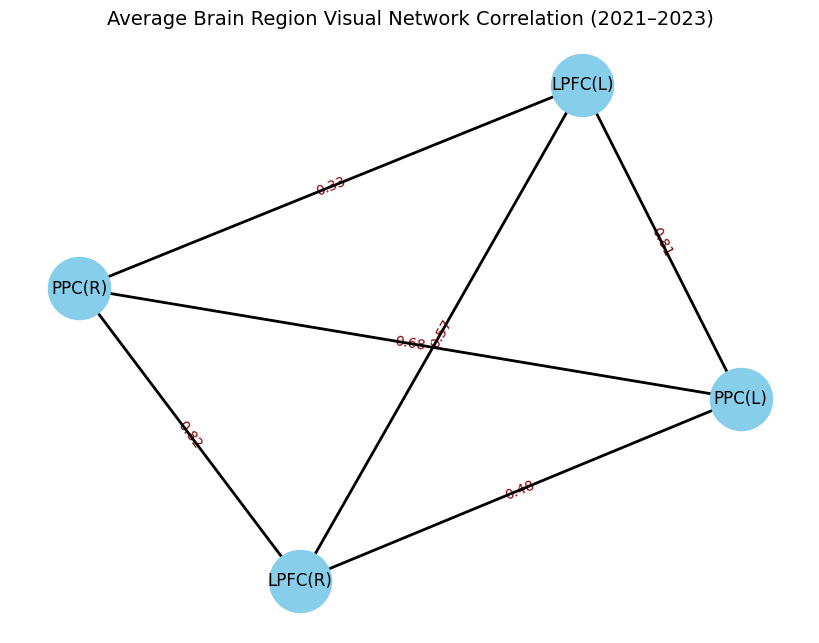

In [42]:
# Define nodes
nodes = get_nodes(connection_columns[:-1])

# Create edge list from average correlations
edges = get_edges(connection_columns[:-1], avg_corr_fp_nt)

# Create graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Visual layout
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')}

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')
nx.draw_networkx_edges(G, pos, width=2)
plt.title("Average Brain Region Visual Network Correlation (2021–2023)", fontsize=14)
plt.show()

#### Statistical Test

In [43]:
matrix_fp = merged_fp.drop(columns=exclude_cols, inplace=False)
matrix_fp

,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC
0,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524
1,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505
2,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746
3,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785
4,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636
...,...,...,...,...,...,...,...
163,0.87263,0.81188,0.39356,0.71426,0.77810,0.92793,0.74973
164,0.78401,0.75501,0.44176,0.51809,0.83209,0.92182,0.70880
165,0.86585,0.32716,0.15942,0.52095,0.51875,1.04740,0.57325
166,0.66677,0.63411,0.45050,0.37356,0.65585,0.77367,0.59241


In [44]:
fp_ttest = ttest(matrix_fp, merged_fp)
fp_ttest

,Connection,t-stat,p-value
0,LPFC(L)-PPC(L),-3.236823,0.001554
1,LPFC(L)-LPFC(R),-1.107002,0.270434
2,LPFC(L)-PPC(R),-0.482755,0.630124
3,PPC(L)-LPFC(R),-1.213126,0.227653
4,PPC(L)-PPC(R),-0.804259,0.422445
5,LPFC(R)-PPC(R),-2.275389,0.024703
6,Averaged_CC,-2.297954,0.023288


In [45]:
# FDR 보정
fp_ttest['FDR_corrected_p'] = multipletests(fp_ttest['p-value'], method='fdr_bh')[1]
fp_ttest['Significant'] = fp_ttest['FDR_corrected_p'] < 0.05
fp_ttest.head()

,Connection,t-stat,p-value,FDR_corrected_p,Significant
0,LPFC(L)-PPC(L),-3.236823,0.001554,0.010877,True
1,LPFC(L)-LPFC(R),-1.107002,0.270434,0.378607,False
2,LPFC(L)-PPC(R),-0.482755,0.630124,0.630124,False
3,PPC(L)-LPFC(R),-1.213126,0.227653,0.378607,False
4,PPC(L)-PPC(R),-0.804259,0.422445,0.492852,False


In [46]:
# 유의한 연결만 보기
significant_connections_fp = fp_ttest[fp_ttest['Significant']]
print(significant_connections_fp)

       Connection    t-stat   p-value  FDR_corrected_p  Significant
0  LPFC(L)-PPC(L) -3.236823  0.001554         0.010877         True


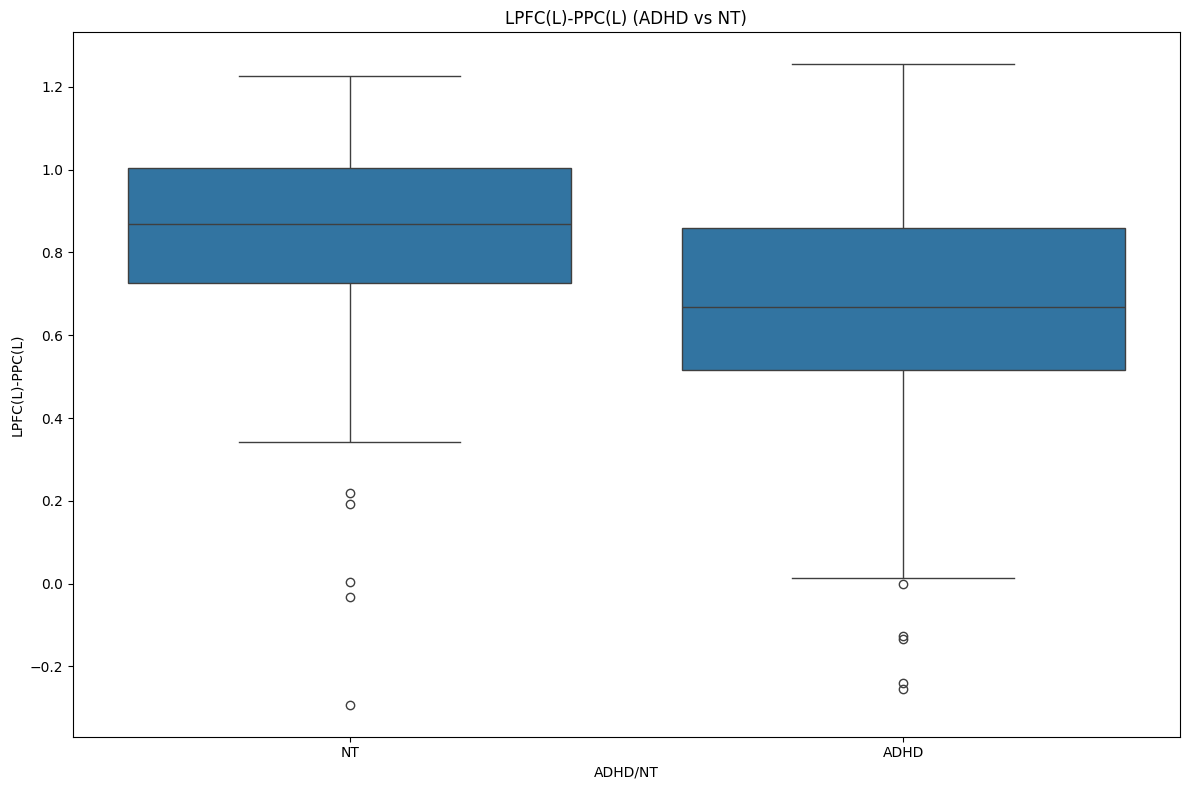

In [47]:
# 가장 유의한 연결 시각화
top_conn_fp = significant_connections_fp.sort_values('FDR_corrected_p').iloc[0]['Connection']

# 단일 subplot 설정
fig, ax = plt.subplots(figsize=(12, 8))

# 첫 번째 boxplot
sns.boxplot(x='ADHD/NT', y=top_conn_fp, data=merged_fp)
ax.set_title(f'{top_conn_fp} (ADHD vs NT)')

plt.tight_layout()
plt.show()

# TESTING

In [48]:
combined_visual.columns

Index(['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition',
       'Medial-Occipital', 'Medial-Lateral(L)', 'Medial-Lateral(R)',
       'Occipital-Lateral(L)', 'Occipital-Lateral(R)', 'Lateral(L)-Lateral(R)',
       'Averaged_CC'],
      dtype='object')

In [49]:
connection_columns = combined_visual.drop(columns=['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition', 'Averaged_CC']).columns.tolist()

avg_corr = combined_visual[connection_columns].mean().round(4)
print(avg_corr)

Medial-Occipital         0.4037
Medial-Lateral(L)        0.6242
Medial-Lateral(R)        0.5274
Occipital-Lateral(L)     0.5248
Occipital-Lateral(R)     0.4245
Lateral(L)-Lateral(R)    1.0160
dtype: float64


In [50]:
def get_nodes(connection_columns):
    # Create an empty list to store the distinct components
    nodes = set()

    # Split each region and add parts to the list
    for region in connection_columns:
        parts = region.replace('-', ' ').split()
        nodes.update(parts)

    return list(nodes)

In [51]:
def get_edges(connection_columns, avg_corr):
    # Create an empty list to store edges
    edges = []
    
    for column in connection_columns:
        # Split the column name to extract the two regions involved
        region1, region2 = column.replace('-', ' ').split()

        # Get the correlation value for this connection
        correlation_value = avg_corr[column]

        # Append the edge (with correlation value as weight)
        edges.append((region1, region2, correlation_value))

    return edges

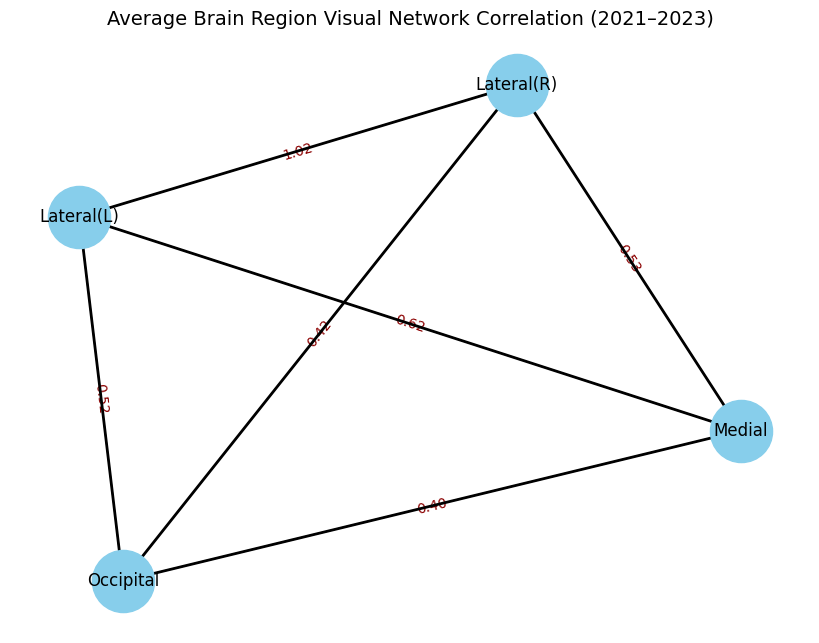

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# Define nodes
nodes = get_nodes(connection_columns)

# Create edge list from average correlations
edges = get_edges(connection_columns, avg_corr)

# Create graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Visual layout
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')}

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')
nx.draw_networkx_edges(G, pos, width=2)
plt.title("Average Brain Region Visual Network Correlation (2021–2023)", fontsize=14)
plt.show()
